## Implementation

In [1]:
from IOHMM import IOHMM_model
import numpy as np, pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# torch.manual_seed(3)

In [2]:
data = pd.read_csv("data/Financial-Data/stocks/TSLA.csv")
data.head()
data = data.dropna()
print(len(data))

input_np = np.array(data[['Open']])
output_np = np.array(data['Close'])

input = torch.tensor(np.array(data[['Open']]), dtype=torch.float32)
output = torch.tensor(np.array(data['Close']), dtype=torch.float32)
difference = np.array(data[['Open']]) - np.array(data[['Close']])

difference = torch.tensor(difference, dtype=torch.float32)
difference = difference.squeeze(1)

# maybe use also open - close previous day as input

3260


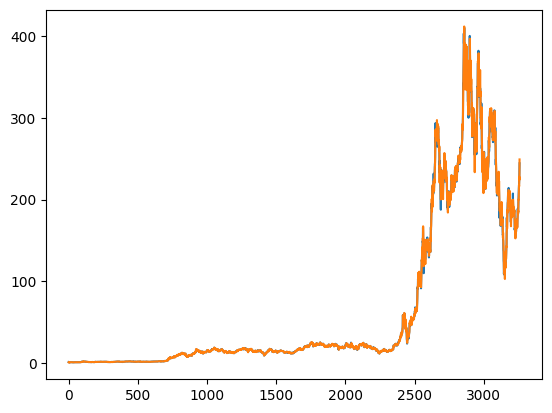

In [3]:
plt.plot(output)
plt.plot(input)

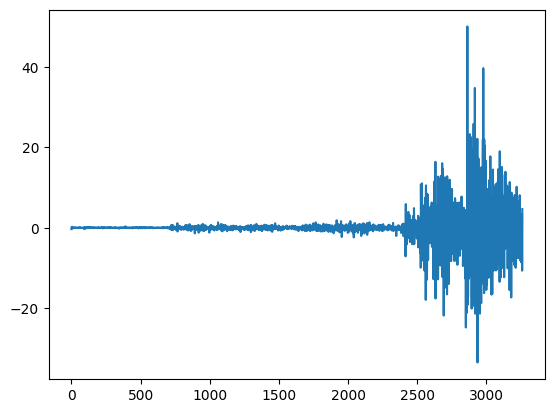

In [4]:
plt.plot(difference)

In [5]:
model = LinearRegression()
print(input_np.shape)
model.fit(input_np[:1000], difference[:1000])
print(model.coef_, model.intercept_)

(3260, 1)
[0.00139058] -0.004760805284243782


# Example 1

## Set up a simple model manully

In [6]:
# taking points from 1500 to the end because they are more interesting

transition_matrix = torch.tensor([[[0.5,0.1],[-0.5,-0.1]],[[-0.5,-0.1],[0.5,0.1]]])
emission_matrix = torch.tensor([[-0.1,0.9],[0.1,0.9]])

IOHMM = IOHMM_model(num_states=2, inputs=input[:100], outputs=difference[:100], max_iter=1000, tol=1e-6, transition_matrix=transition_matrix, emission_matrix=emission_matrix)
print(IOHMM.initial_pi)
print(IOHMM.transition_matrix)
print(IOHMM.emission_matrix)
print(IOHMM.sd)

Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([[[ 0.5000,  0.1000],
         [-0.5000, -0.1000]],

        [[-0.5000, -0.1000],
         [ 0.5000,  0.1000]]], requires_grad=True)
Parameter containing:
tensor([[-0.1000,  0.9000],
        [ 0.1000,  0.9000]], requires_grad=True)
Parameter containing:
tensor([5., 5.], requires_grad=True)


In [7]:
forward = IOHMM._forward()
print(forward)

tensor([[0.5029, 0.4971],
        [0.5046, 0.4954],
        [0.5052, 0.4948],
        [0.5053, 0.4947],
        [0.5048, 0.4952],
        [0.5045, 0.4955],
        [0.5046, 0.4954],
        [0.5046, 0.4954],
        [0.5046, 0.4954],
        [0.5047, 0.4953],
        [0.5050, 0.4950],
        [0.5052, 0.4948],
        [0.5054, 0.4946],
        [0.5057, 0.4943],
        [0.5057, 0.4943],
        [0.5056, 0.4944],
        [0.5057, 0.4943],
        [0.5058, 0.4942],
        [0.5058, 0.4942],
        [0.5057, 0.4943],
        [0.5057, 0.4943],
        [0.5057, 0.4943],
        [0.5056, 0.4944],
        [0.5056, 0.4944],
        [0.5058, 0.4942],
        [0.5059, 0.4941],
        [0.5058, 0.4942],
        [0.5056, 0.4944],
        [0.5055, 0.4945],
        [0.5053, 0.4947],
        [0.5051, 0.4949],
        [0.5049, 0.4951],
        [0.5049, 0.4951],
        [0.5050, 0.4950],
        [0.5051, 0.4949],
        [0.5051, 0.4949],
        [0.5051, 0.4949],
        [0.5051, 0.4949],
        [0.5

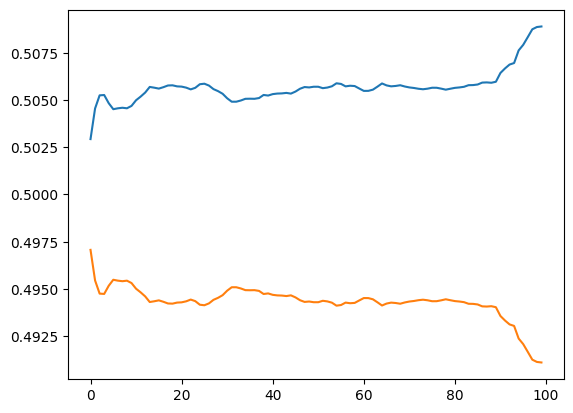

In [8]:
plt.plot(forward[:, 0])
plt.plot(forward[:, 1])

In [9]:
print(IOHMM._backward())
torch.sum(IOHMM._backward(), dim=1)

tensor([[0.5063, 0.4937],
        [0.5060, 0.4940],
        [0.5054, 0.4946],
        [0.5048, 0.4952],
        [0.5044, 0.4956],
        [0.5044, 0.4956],
        [0.5047, 0.4953],
        [0.5048, 0.4952],
        [0.5049, 0.4951],
        [0.5052, 0.4948],
        [0.5055, 0.4945],
        [0.5056, 0.4944],
        [0.5058, 0.4942],
        [0.5058, 0.4942],
        [0.5056, 0.4944],
        [0.5057, 0.4943],
        [0.5058, 0.4942],
        [0.5058, 0.4942],
        [0.5057, 0.4943],
        [0.5056, 0.4944],
        [0.5056, 0.4944],
        [0.5056, 0.4944],
        [0.5056, 0.4944],
        [0.5058, 0.4942],
        [0.5058, 0.4942],
        [0.5056, 0.4944],
        [0.5054, 0.4946],
        [0.5052, 0.4948],
        [0.5051, 0.4949],
        [0.5050, 0.4950],
        [0.5048, 0.4952],
        [0.5049, 0.4951],
        [0.5050, 0.4950],
        [0.5051, 0.4949],
        [0.5052, 0.4948],
        [0.5051, 0.4949],
        [0.5052, 0.4948],
        [0.5053, 0.4947],
        [0.5

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [10]:
print(IOHMM._compute_gamma(IOHMM._forward(), IOHMM._backward()))
torch.sum(IOHMM._compute_gamma(IOHMM._forward(), IOHMM._backward()), dim=1)

tensor([[0.5092, 0.4908],
        [0.5105, 0.4895],
        [0.5106, 0.4894],
        [0.5100, 0.4900],
        [0.5092, 0.4908],
        [0.5090, 0.4910],
        [0.5093, 0.4907],
        [0.5094, 0.4906],
        [0.5095, 0.4905],
        [0.5099, 0.4901],
        [0.5105, 0.4895],
        [0.5108, 0.4892],
        [0.5112, 0.4888],
        [0.5115, 0.4885],
        [0.5113, 0.4887],
        [0.5113, 0.4887],
        [0.5115, 0.4885],
        [0.5116, 0.4884],
        [0.5115, 0.4885],
        [0.5114, 0.4886],
        [0.5114, 0.4886],
        [0.5113, 0.4887],
        [0.5112, 0.4888],
        [0.5114, 0.4886],
        [0.5117, 0.4883],
        [0.5115, 0.4885],
        [0.5112, 0.4888],
        [0.5108, 0.4892],
        [0.5106, 0.4894],
        [0.5103, 0.4897],
        [0.5099, 0.4901],
        [0.5098, 0.4902],
        [0.5099, 0.4901],
        [0.5101, 0.4899],
        [0.5102, 0.4898],
        [0.5102, 0.4898],
        [0.5102, 0.4898],
        [0.5104, 0.4896],
        [0.5

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [11]:
print(IOHMM._compute_xi(IOHMM._forward(), IOHMM._backward()))
a = torch.sum(IOHMM._compute_xi(IOHMM._forward(), IOHMM._backward()), axis=1)
torch.sum(a, axis=1)

tensor([[[0.4008, 0.1104],
         [0.1116, 0.3772]],

        [[0.4036, 0.1041],
         [0.1028, 0.3895]],

        [[0.4036, 0.1045],
         [0.1041, 0.3879]],

        [[0.4014, 0.1064],
         [0.1066, 0.3856]],

        [[0.3976, 0.1097],
         [0.1101, 0.3826]],

        [[0.3931, 0.1140],
         [0.1142, 0.3788]],

        [[0.3927, 0.1144],
         [0.1143, 0.3785]],

        [[0.3945, 0.1127],
         [0.1126, 0.3801]],

        [[0.3951, 0.1123],
         [0.1122, 0.3804]],

        [[0.3946, 0.1131],
         [0.1128, 0.3795]],

        [[0.3956, 0.1125],
         [0.1121, 0.3798]],

        [[0.3983, 0.1101],
         [0.1098, 0.3818]],

        [[0.3995, 0.1092],
         [0.1090, 0.3823]],

        [[0.4005, 0.1084],
         [0.1082, 0.3829]],

        [[0.4011, 0.1078],
         [0.1078, 0.3833]],

        [[0.3997, 0.1091],
         [0.1091, 0.3820]],

        [[0.3996, 0.1094],
         [0.1093, 0.3818]],

        [[0.4004, 0.1086],
         [0.1085, 0.3

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [12]:
IOHMM._log_likelihood(IOHMM._compute_gamma(IOHMM._forward(), IOHMM._backward()), IOHMM._compute_xi(IOHMM._forward(), IOHMM._backward()))

tensor(-309.1257, grad_fn=<AddBackward0>)

In [13]:
IOHMM._baum_welch()

1 -292.17108154296875
2 -292.170654296875
convergence reached :)
-292.170654296875


## See the training results

In [14]:
print("Initial pi")
print(IOHMM.initial_pi) # to normalize, initial pi becomes very big, why(?)
print("Transition matrix")
print(IOHMM.transition_matrix)
print("Emission matrix")
print(IOHMM.emission_matrix)
print("Sd")
print(IOHMM.sd)

Initial pi
Parameter containing:
tensor([11675706., 11403748.], requires_grad=True)
Transition matrix
Parameter containing:
tensor([[[ 0.5000,  0.1000],
         [-0.5000, -0.1000]],

        [[-0.5000, -0.1000],
         [ 0.5000,  0.1000]]], requires_grad=True)
Emission matrix
Parameter containing:
tensor([[-0.1000,  0.9000],
        [ 0.1000,  0.9000]], requires_grad=True)
Sd
Parameter containing:
tensor([5., 5.], requires_grad=True)


## Viterbi

In [15]:
path = IOHMM.viterbi()
print(path)
path[path==0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0